#AI In Industry Project
###team members:
#####Parsa Mastouri Kashani
#####Freddy Fernandes
#####Arina Sadeghi Khiabanian

##SYSTEM SETUP

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


##Downloading the dataset(ECG)

In [ ]:
!gdown https://www.timeseriesclassification.com/aeon-toolkit/ECG5000.zip

Downloading...
From: https://www.timeseriesclassification.com/aeon-toolkit/ECG5000.zip
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 11.2MB/s]


##Unzipping the dataset file

In [ ]:
!unzip ECG5000.zip

Archive:  ECG5000.zip
  inflating: ECG5000.txt             
  inflating: ECG5000_TEST.arff       
  inflating: ECG5000_TEST.txt        
  inflating: ECG5000_TRAIN.arff      
  inflating: ECG5000_TRAIN.txt       
  inflating: ECG5000_TEST.ts         
  inflating: ECG5000_TRAIN.ts        


##Importing Necessary Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import os

## 1. Data Loading and Preprocessing

In [ ]:
from scipy.io.arff import loadarff
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import time
import copy
import shutil
import seaborn as sns
import numpy as np
import torch
import pandas as pd

from torch import nn, optim


from matplotlib import pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms, models

## Configure plotting, set hyperparameters, and define device for PyTorch.


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format="retina"

sns.set(style="whitegrid", palette="muted", font_scale=1.2)

plt.rcParams["figure.figsize"] = 12, 8

BATCH_SIZE = 16
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load training data and test data from ECG files.


In [ ]:
with open("ECG5000_TRAIN.arff") as f:
  data, _ = loadarff(f)
  train = pd.DataFrame(data)

with open("ECG5000_TEST.arff") as f:
  data, _ = loadarff(f)
  test = pd.DataFrame(data)

In [ ]:
df =train.append(test)
df=df.sample(frac=1.0)

<ipython-input-101-13b449d30a65>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df =train.append(test)


In [ ]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,b'1'
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,b'1'
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,b'1'
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,b'1'
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,b'1'


## Display unique values in the "target" column


In [ ]:
df["target"].unique()

array([b'1', b'3', b'2', b'4', b'5'], dtype=object)

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
# First, convert the column to string type
df['target'] = df['target'].astype(str)

# Then replace the values
df['target'] = df['target'].replace({'b\'1\'': '0', 'b\'2\'': '1', 'b\'3\'': '1', 'b\'4\'': '1', 'b\'5\'': '1'})

# Finally, convert the column back to integer type if needed
df['target'] = df['target'].astype(int)

In [ ]:
df["target"].unique()

array([0, 1])

##Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the normal dataset for training and validation purposes
training_df, validation_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
validation_df, test_df = train_test_split(validation_df, test_size=0.4, random_state=RANDOM_SEED)

print(len(training_df))
print(len(validation_df))
print(len(test_df))

4000
600
400


##Classification model

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Define your custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32)
        return sample

# Creating dataset instances for training, validation, testing, and anomalies
training_dataset = CustomDataset(training_df)
validation_dataset = CustomDataset(validation_df)
testing_dataset = CustomDataset(test_df)

# Creating DataLoader instances to facilitate batch processing and shuffling
training_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
testing_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the binary classification model with six layers
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(BinaryClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        self.hidden_layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)])
        self.output_layer = nn.Linear(hidden_sizes[-1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        out = self.output_layer(x)
        out = self.sigmoid(out)
        return out

# Example usage
input_size = 140  # Input dimensionality
hidden_sizes = [100, 80, 60, 40, 20, 10]  # Number of neurons in each hidden layer
model = BinaryClassifier(input_size, hidden_sizes)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Using Adam optimizer

##Training

In [ ]:
def train(model, dataloader, optimizer, criterion):
    # Switch model to training mode
    model.train()
    for batch in dataloader:
        # Forward pass
        input = batch[:, :-1].to(device)
        target = batch[:, -1].unsqueeze(1).to(device)
        output = model(input).to(device)
        loss = criterion(output, target)

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
def validation(epoch, val_loss_min_input, model, dataloader, criterion):
    num_batches = len(dataloader)
    # Switch to evaluation mode
    model.eval()
    val_loss = 0
    with torch.no_grad():
      for batch in dataloader:
        # Forward pass
        input = batch[:, :-1].to(device)
        target = batch[:, -1].unsqueeze(1).to(device)
        output = model(input).to(device)
        # Compute validation loss
        val_loss += criterion(output, target).item()

      # Average validation loss
      val_loss /= num_batches
      print(val_loss)

      #outputs, targets = fin_outputs, fin_targets
      print(f"\nValidation loss: {val_loss:>8f}.")
      ## save the model if validation loss has decreased
      if val_loss <= val_loss_min_input:
          #create checkpoint variable and add important data
          if epoch > 0:
              print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss))
          else: print('Saving model ...')
          # save best model
          torch.save(model.state_dict(), f"emo_model_epoch_{epoch}.pth")
          print("Saved PyTorch Model State to model.pth\n")
          val_loss_min_input = val_loss
      else:
        print('validation loss didn\'t go down -____-')

      return val_loss_min_input

In [ ]:
EPOCHS=100

In [ ]:
# Setting initial minimum validation loss to infinity for comparison
val_loss_min = np.Inf
# Training and validating model
for epoch in range(EPOCHS):
  train(model,
        training_loader,
        optimizer,
        #scheduler,
        #LEARNING_RATE,
        #EPOCHS,
        #epoch,
        criterion)
  val_loss_min = validation(epoch,
                            val_loss_min,
                            model,
                            validation_loader,
                            criterion,
                            )

0.6850185566826871

Validation loss: 0.685019.
Saving model ...
Saved PyTorch Model State to model.pth

0.6755757786725697

Validation loss: 0.675576.
Validation loss decreased (0.68501856 --> 0.67557578).  Saving model ...
Saved PyTorch Model State to model.pth

0.6601372737633554

Validation loss: 0.660137.
Validation loss decreased (0.67557578 --> 0.66013727).  Saving model ...
Saved PyTorch Model State to model.pth

0.635545867054086

Validation loss: 0.635546.
Validation loss decreased (0.66013727 --> 0.63554587).  Saving model ...
Saved PyTorch Model State to model.pth

0.5808989954622168

Validation loss: 0.580899.
Validation loss decreased (0.63554587 --> 0.58089900).  Saving model ...
Saved PyTorch Model State to model.pth

0.49469668614236934

Validation loss: 0.494697.
Validation loss decreased (0.58089900 --> 0.49469669).  Saving model ...
Saved PyTorch Model State to model.pth

0.3737035738794427

Validation loss: 0.373704.
Validation loss decreased (0.49469669 --> 0.37370

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, classification_report

##Threshold
The get_threshold function aims to find an optimal threshold for classification based on maximizing the F1 score, which balances precision and recall, and it provides visualization of the precision-recall curve for analysis.

In [ ]:
# Function to get the threshold for trigger classification
def get_threshold(model, dataloader):
    # Evaluate different thresholds and choose the one with the highest F1 score
    model.eval()

    targets=[]
    outputs=[]
    with torch.no_grad():
      for batch in dataloader:
        # Forward pass
        input = batch[:, :-1].to(device)
        target = batch[:, -1].unsqueeze(1).to(device)
        output = model(input).to(device)

        targets.extend(target.squeeze(1).cpu().detach().numpy().tolist())
        outputs.extend(output.squeeze(1).cpu().detach().numpy().tolist())

      # precision and recall
      precision, recall, thresholds = precision_recall_curve(targets, outputs)

      # computing the F1 score for each threshold value
      pr, p_r = (precision * recall), (precision + recall)
      f1_scores = [2*(pr/p_r) if p_r > 0 else 0 for pr, p_r in zip(pr, p_r)]

      # find the index of the maximum F1-score
      best_threshold_index = np.argmax(f1_scores)

      # get the best threshold, Precision, Recall values
      best_threshold = thresholds[best_threshold_index]
      best_precision, best_recall = precision[best_threshold_index], recall[best_threshold_index]

      best_metrics = {'Best F1 Score':np.max(f1_scores),
                      'Best threshold':best_threshold,
                      'Best precision':best_precision,
                      'Best recall':best_recall}

      print(f"\nMetrics:\n{best_metrics}")

      # plot the PR curve
      plt.figure(figsize=(4,3))
      plt.plot(recall, precision, color= 'black', label='PR curve')
      plt.scatter(best_recall, best_precision, color='tab:red', label='Best PR - Max F1 Score')

      # setting the plot parms
      plt.xlim([-0.05, 1.05])
      plt.ylim([-0.05, 1.05])
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.legend()
      plt.title('Precision-Recall Curve')

      plt.show()

      return best_threshold


Metrics:
{'Best F1 Score': 0.9868173258003766, 'Best threshold': 0.2318757027387619, 'Best precision': 0.9886792452830189, 'Best recall': 0.9849624060150376}


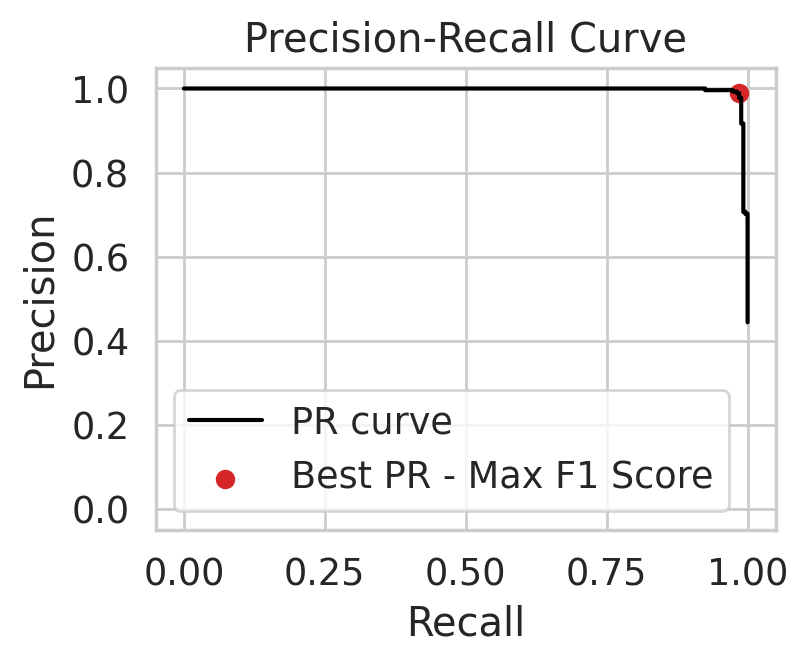

In [ ]:
threshold = get_threshold(model, validation_loader)

In [ ]:
def test(model, dataloader, threshold):
    # Evaluate different thresholds and choose the one with the highest F1 score
    model.eval()

    targets=[]
    outputs=[]
    with torch.no_grad():
      for batch in dataloader:
        # Forward pass
        input = batch[:, :-1].to(device)
        target = batch[:, -1].unsqueeze(1).to(device)
        output = model(input).to(device)

        targets.extend(target.squeeze(1).cpu().detach().numpy().tolist())
        outputs.extend(output.squeeze(1).cpu().detach().numpy().tolist())

    return targets, np.array(outputs >= threshold).astype(int).tolist()

In [ ]:
targets, outputs = test(model, testing_loader, threshold)
print(classification_report(targets, outputs))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       235
         1.0       0.99      0.99      0.99       165

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

